In [1]:
import itertools
import os

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk

plt.rcParams["figure.figsize"] = (12,8)

In [2]:
DATA_DIR = "data"

In [3]:
CORRUPTED_TRENDING_COLS = set(['RateTrackEventsTheta0_10',
                               'RateTrackEventsTheta10_20',
                               'RateTrackEventsTheta20_30',
                               'RateTrackEventsTheta30_40',
                               'RateTrackEventsTheta40_50',
                               'RateTrackEventsTheta50_60',
                               'RateTrackEventsTheta60_90',
                               'AvTOTBot', 'AvTOTMid', 'AvTOTTop'])

Read the data into dataframes. For `Trending` we noticed that some files miss columns `CORRUPTED_TRENDING_COLS`. We decided to normalize all the data, and drop these columns from everywhere (since we don't plan to use them in the project anyways). At the same time we collect copies of corrupted data in the separate dataframe for future investigations

In [4]:
def struct_files(files):
    header = None
    weather = None
    trending = None
    for f in files:
        if not f.endswith(".csv"):
            continue
        if "Header" in f:
            header = f
        elif "Weather" in f:
            weather = f
        elif "Trending" in f:
            trending = f
    return header, weather, trending

In [5]:
def assemble_cuts(df, cut_list):
    res = []
    for cut_name in cut_list:
        cut = CUTS
        for path_part in cut_name.split("."):
            cut = cut[path_part]
        res.append(cut(df))
    return np.any(res, axis=0)

In [6]:
# which lines to drop

CUTS = {
    "runs": {
        "small_event_number": lambda df: df["NumEvents"] < 12000,
        "run_time_too_long": lambda df: ((df["RunStop"] - df["RunStart"]) > 1000000),
        "run_time_too_short": lambda df: ((df["RunStop"] - df["RunStart"]) < 60*10),
        "pola3_perturb_time": lambda df: (df["RunNumber"] < 3661E5) & (df["RunNumber"] > 3654E5)
    }
}

In [13]:
def parse_header(path, tid):
    read_h = pd.read_csv(path, header=0).rename(columns={"#RunNumber": "RunNumber"})
    read_h["telescope"] = pd.Series(np.full_like(read_h["telescope"], tid))
    return read_h

In [14]:
def parse_weather(path):
    read_w = pd.read_csv(path, header=0).rename(columns={"#Seconds": "Seconds"})
    return read_w

In [15]:
def parse_events(path, runs):
    read_t = pd.read_csv(path, header=0).rename(columns={"#BinStart": "BinStart"})
    
    corrupted = CORRUPTED_TRENDING_COLS - set(read_t.columns)
    cols_to_drop = set(read_t.columns) & CORRUPTED_TRENDING_COLS
    read_t.drop(columns=cols_to_drop, inplace=True)
    read_t = pd.merge(runs[["telescope", "UniqueRunId"]], read_t, on="UniqueRunId", how="left")
    
    return read_t, corrupted

In [16]:
class CorruptedRecordException(Exception):
    pass

In [17]:
def parse_runs(header_f, weather_f, resource):
    header_d = parse_header(header_f, resource)
    if header_d.shape[0] == 0:
        raise CorruptedRecordException(f"Corrupted header: {h}")

    weather_d = parse_weather(weather_f)
    if weather_d.shape[0] == 0:
        raise CorruptedRecordException(f"Corrupted weather: {w}")

    runs = pd.merge(header_d, weather_d, on="UniqueRunId", how="left", validate="one_to_one")

    header_missing_weather = np.count_nonzero(~np.isin(header_d["UniqueRunId"], weather_d["UniqueRunId"]))
    if header_missing_weather:
        print(f"Header missing Weather: {header_missing_weather}. {header_f.split('/')[-1]}")

    run_cuts = assemble_cuts(runs, ["runs.small_event_number", 
                                    "runs.run_time_too_long",
                                    "runs.run_time_too_short"])
    
    return runs[~run_cuts]

In [18]:
data_map = {"Runs": [], "Events": []}


for resource in ["POLA-01", "POLA-02", "POLA-03"]:
    for root, dirs, files in os.walk(os.path.join(DATA_DIR, resource)):
        if not files:
            continue
        if len(files) != 3:
            print(f"Suspicious data in {root}")
        h, w, t = struct_files(files)
        
        try:
            runs = parse_runs(os.path.join(root, h),
                              os.path.join(root, w),
                              resource)
            data_map["Runs"].append(runs)
        except CorruptedRecordException as e:
            print(e)
            continue
        
        events, events_corrupted = parse_events(os.path.join(root, t), runs)
        data_map["Events"].append(events)
        if events_corrupted:
            print(f"Corrupted events: ts {events['BinStart'].iloc[0]} - {events['BinEnd'].iloc[-1]}. {root}/{t}")
            
        events_without_header = np.count_nonzero(~events["UniqueRunId"].isin(runs["UniqueRunId"]))
        if events_without_header:
            print(f"There are events without header: {events_without_header}. {root}/{t}")

Corrupted events: ts 364521650.0 - 364607881.0. data/POLA-01/2018-07-21/POLA-01_2018-07-21_2018-07-21_summary_Trending.csv
Corrupted events: ts 364694646.0 - 364852038.0. data/POLA-02/2018-07-24/POLA-02_2018-07-23_2018-07-24_summary_Trending.csv
Corrupted events: ts 364522419.0 - 364608495.0. data/POLA-02/2018-07-21/POLA-02_2018-07-21_2018-07-21_summary_Trending.csv
Corrupted events: ts 364954724.0 - 365116627.0. data/POLA-02/2018-07-27/POLA-02_2018-07-26_2018-07-27_summary_Trending.csv
Corrupted events: ts 364781126.0 - 364934932.0. data/POLA-02/2018-07-25/POLA-02_2018-07-24_2018-07-25_summary_Trending.csv
Corrupted events: ts 364608549.0 - 364694595.0. data/POLA-02/2018-07-22/POLA-02_2018-07-22_2018-07-22_summary_Trending.csv
Corrupted events: ts 364694646.0 - 364781077.0. data/POLA-02/2018-07-23/POLA-02_2018-07-23_2018-07-23_summary_Trending.csv
Corrupted events: ts 364867798.0 - 365031132.0. data/POLA-02/2018-07-26/POLA-02_2018-07-25_2018-07-26_summary_Trending.csv
Corrupted events

In [19]:
runs = pd.concat(data_map["Runs"]).sort_values("RunNumber", axis="index").reset_index(drop=True)
events = pd.concat(data_map["Events"]).sort_values(["UniqueRunId", "BinStart"], axis="index").reset_index(drop=True)

Quality checks and alignment checks for `Header` and `Weather` timestamps. It turns out that there are 49 of ~13500 rows that are missaligned by 1 or 2 seconds. Good thing to be aware of.

In [20]:
# total number of events
print("Runs: ", runs.shape[0])

# how many runs for tracking do we have?
print("Runs for tracking: ", np.unique(events["UniqueRunId"]).shape)

# test RunDuration consistency
assert np.all(np.isclose(runs["RunStop"] - runs["RunStart"], runs["RunDuration"]))

# how many timestamp misalignments are there?
mask = (runs["RunNumber"] != runs["Seconds"])
(runs[mask]["Seconds"] - runs[mask]["RunNumber"]).describe()

Runs:  13036
Runs for tracking:  (8120,)


count    46.000000
mean      1.021739
std       0.147442
min       1.000000
25%       1.000000
50%       1.000000
75%       1.000000
max       2.000000
dtype: float64

`RunNumber` (form header) is almost the same as `Seconds` (from weather), and apparently means a moment of measuring the weather for specific run. `RunStart` is an exact time of run start. We see that there was a region between 365.5-366.5 MegaSeconds($10^6 s \approx 10~days$), where we've got weather measures delayed (why?). If converted to real world dates, the timerange of the artifact corresponds to 1-10 Aug 2018.

We also have some dramatic misses in temperature measures for few points. For this runs, weather was measured ~30s in advance before actual run

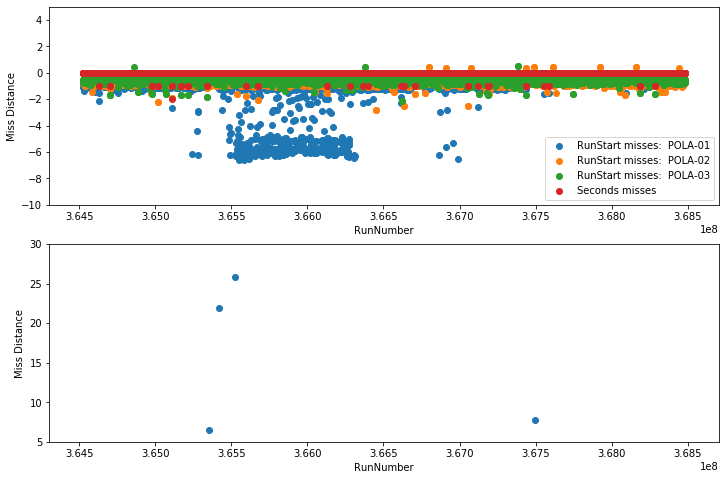

In [21]:
def plot_misses(axes, runs):
    ax = axes[0]
    runs.groupby("telescope", group_keys=True).apply(lambda tsc: \
        ax.scatter(tsc["RunNumber"], tsc["RunNumber"]-tsc["RunStart"], label=f"RunStart misses:  {tsc['telescope'].iloc[0]}")
    )
    ax.scatter(runs["RunNumber"], runs["RunNumber"]-runs["Seconds"], label=f"Seconds misses")
    ax.legend()
    ax.set_xlabel("RunNumber")
    ax.set_ylabel("Miss Distance")
    ax.set_ylim([-10, 5]);
    
    ax = axes[1]
    runs.groupby("telescope", group_keys=True).apply(lambda tsc: \
        ax.scatter(tsc["RunNumber"], tsc["RunNumber"]-tsc["RunStart"], label=f"RunStart misses:  {tsc['telescope'].iloc[0]}")
    )
    ax.set_xlabel("RunNumber")
    ax.set_ylabel("Miss Distance")
    ax.set_ylim([5, 30]);

fig, ax = plt.subplots(2)
plot_misses(ax, runs)

In [221]:
def binned_agg(df, xlabel, ylabel, agg, binsize, groups="telescope", agg_err=None):
    if agg_err is None:
        def error_func(x):
            return np.sqrt(np.mean((x - agg(x))**2))
    else:
        def error_func(x):
            return agg_err(x)
    def agg_func(x):
        # pandas is buggy with lambdas, they are unnamed :(
        return agg(x)
    
    def process_group(group_df):
        bins = np.arange(df[xlabel].values.min(), df[xlabel].values.max(), binsize)
        return group_df.set_index(xlabel)[[ylabel]] \
            .groupby(lambda idx: bins[np.searchsorted(bins, idx) - 1]) \
            .agg(**{
                ylabel: (ylabel, agg_func),
                f"{ylabel}_err": (ylabel, error_func)
            }).rename_axis(index={None: xlabel})
    
    if groups is not None:
        means = df.groupby(groups).apply(process_group)
    else:
        means = process_group(df)
        
    return means

In [93]:
np.percentile(events[events["telescope"] == "POLA-03"]["BinStart"].iloc[1:].values - events[events["telescope"] == "POLA-03"]["BinStart"].iloc[:-1].values, 99)

90.0

### 3.1 Environmental conditions

Here we show plots for IndoorTemperature, OutdoorTemperature and Pressure depending on time and a telescope. From the plots we can see that, as expected, `POLA-01` has very variable measures because it is drifting through the ocean.

What is also interesting, is that the artifact we saw in `RunStart misses` plot above (for POLA-01) was happening close to the time region we see here, but for POLA-03. Mystery.


In [94]:
binned_agg(events, "BinStart", "IndoorTemperature", np.mean, 60*10).groupby("telescope").describe()

IndoorTemperature                                           \
                      count       mean       std       min       25%   
telescope                                                              
POLA-01              5162.0  25.355638  2.789432  17.34211  23.40022   
POLA-02              6453.0  25.058712  0.135107  24.64132  24.96511   
POLA-03              6455.0  33.355459  0.842530  29.09589  33.04969   

                                          IndoorTemperature_err            \
                 50%        75%       max                 count      mean   
telescope                                                                   
POLA-01    25.171050  27.370610  32.47807                5162.0  0.049343   
POLA-02    25.060340  25.155570  25.49840                6453.0  0.018065   
POLA-03    33.593597  33.846729  36.75874                6455.0  0.037537   

                                                                 
                std  min  25%           50%       75%       max  
telescope                                                        
POLA-01    0.119290  0.0  0.0  0.000000e+00  0.029827  1.407898  
POLA-02    0.031331  0.0  0.0  3.552714e-15  0.027993  0.217674  
POLA-03    0.091167  0.0  0.0  7.105427e-15  0.037422  1.180435

In [95]:
def plot_weather(ax, col, binsize):
    binned_agg(events, "BinStart", col, np.mean, binsize) \
        .groupby(level=0) \
        .apply(lambda tsc: \
            ax.errorbar(x=tsc.index.get_level_values(1),
                        y=tsc[col],
                        yerr=tsc[f"{col}_err"],
                        label=tsc.index.get_level_values(0)[0],
                        fmt=".")
        )
    ax.legend()
    ax.set_ylabel(col);
    ax.set_xlabel(f"BinStart, binsize={binsize}");
    ax.axvline(runs[assemble_cuts(runs, ["runs.pola3_perturb_time"])]["Seconds"].values[0], ls="--", color="lightgray")
    ax.axvline(runs[assemble_cuts(runs, ["runs.pola3_perturb_time"])]["Seconds"].values[-1], ls="--", color="lightgray")

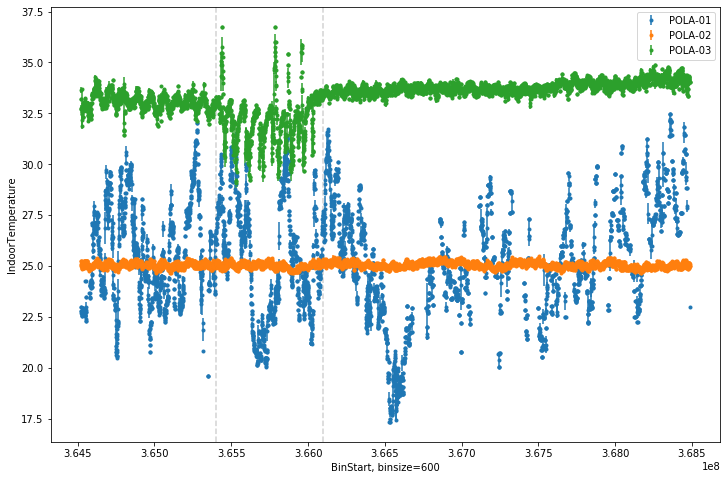

In [96]:
fig, ax = plt.subplots()
plot_weather(ax, "IndoorTemperature", 600)

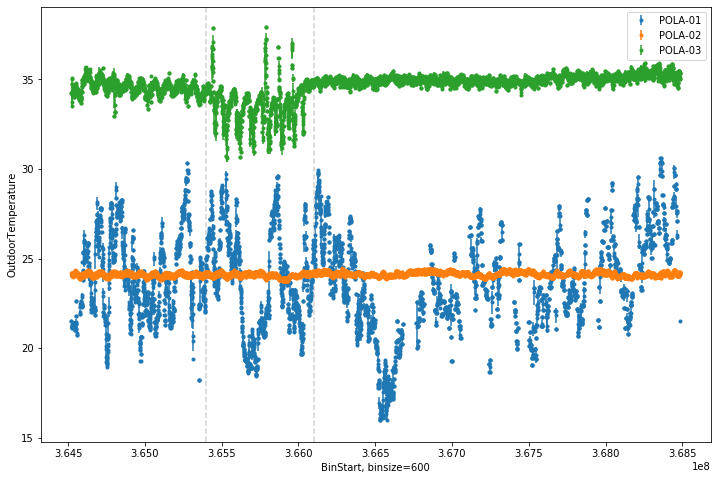

In [97]:
fig, ax = plt.subplots()
plot_weather(ax, "OutdoorTemperature", 600)

We also notice that POLA-03 has better cooling system, `IndoorTemperature` is significantly lower than `OutdoorTemperature` for POLA-03. For other telescopes difference is not that explicit.

Finally, pressure plots show that while pressure conditions are quite similar for POLA-01 and POLA-02, since POLA-03 is located 250m heigher, POLA-03 shows significant pressure drop. That's why in the following steps, to conduct a collective study of data from all the telescopes, we'll have to introduce barometric correction.

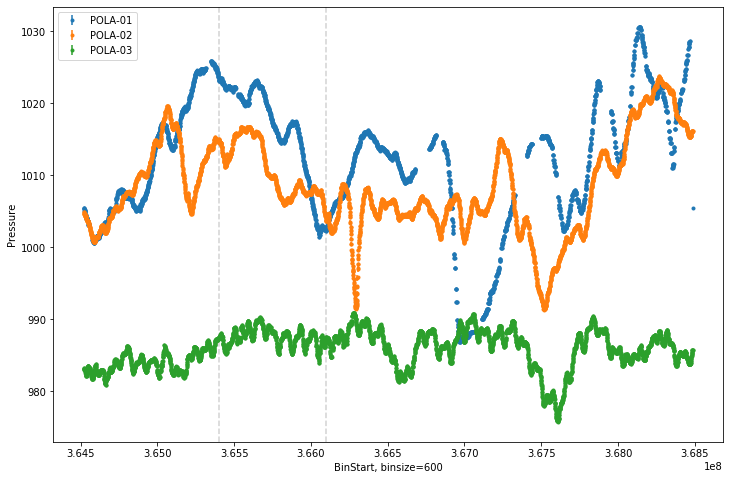

In [98]:
fig, ax = plt.subplots()
plot_weather(ax, "Pressure", 600)

### 3.2 Particle raw rate

In [99]:
runs.groupby("telescope").apply(lambda x: (x["RunDuration"]).describe())

RunDuration,count,mean,std,min,25%,50%,75%,max
telescope,,,,,,,,
POLA-01,2144.0,1375.945432,339.154096,611.045794,1192.727826,1211.364285,1262.869318,2150.878952
POLA-02,5778.0,1188.159916,59.175409,600.270483,1186.452713,1195.715225,1206.518553,1323.544574
POLA-03,5114.0,1353.008754,68.360951,617.554274,1354.545375,1361.137087,1367.289846,1577.140166


As we can see from the RunDuration distribution descriptive statistics, running times might vary from 10 to 20 minutes. It means, that at the timescale of 12h it is acceptable to neglect overlaps over timebins, and assign to one bin those events which has their `RunStart` within the bin, and not care much about `RunStop`. 

In [100]:
avg_rate_color_map = {"POLA-02": plt.get_cmap("tab10")(1),
                      "POLA-03": plt.get_cmap("tab10")(2),
                      "POLA-01": plt.get_cmap("tab10")(0)}

In [141]:
def pivot_on_binned_time(df, xlabel, xagg, xagg_err, binsize, on="RunStart", ylabel="NumEvents", yagg=None, yagg_err=None):
    if yagg is None:
        yagg = lambda x: np.sum(x)/binsize
    if yagg_err is None:
        yagg_err = lambda x: np.sqrt(x.sum())/binsize
    binned_numevents = binned_agg(df, on, ylabel, yagg, binsize, agg_err=yagg_err) \
    
    newx = binned_agg(df, on, xlabel, xagg, binsize, agg_err=xagg_err).reset_index(drop=False)
    return binned_numevents\
                .reset_index(drop=False) \
                .merge(newx, on=["telescope", on]) \
                .drop(columns=[on]) \
                .groupby("telescope") \
                .apply(lambda df: df.sort_values(["telescope", xlabel], axis=0)) \
                .set_index(["telescope"])

In [142]:
def show_sorted_legend(ax):
    if not isinstance(ax, list):
        ax = [ax]
    ax_iter = iter(ax)
    for a in ax_iter:
        a.legend(*zip(*sorted(zip(*a.get_legend_handles_labels()), key=lambda t: t[1])))

In [143]:
runs.columns

Index(['RunNumber', 'RunStart', 'RunStop', 'RunDuration', 'NumEvents',
       'NumHitEvents', 'NumTrackEvents', 'NumNoHitEvents', 'NumNoHitsEvents',
       'NumMalformedEvents', 'NumBackwardEvents', 'eeeVersion', 'telescope',
       'year', 'month', 'day', 'angle', 'Zbottom', 'Zmiddle', 'latitude',
       'longitude', 'altitude', 'nSatellites', 'UniqueRunId', 'DeadChMaskBot',
       'DeadChMaskMid', 'Seconds', 'IndoorTemperature', 'OutdoorTemperature',
       'Pressure'],
      dtype='object')

In [145]:
pivot_on_binned_time(runs, "Pressure", np.median, None, 60*60*12)

,NumEvents,NumEvents_err,Pressure,Pressure_err
telescope,,,,
POLA-01,20.297292,0.021676,987.61170,2.381993
POLA-01,21.787292,0.022457,987.93750,0.393032
POLA-01,13.425440,0.017629,988.13920,0.099692
POLA-01,26.952315,0.024978,990.77110,0.665507
POLA-01,26.468194,0.024753,993.86280,0.731170
...,...,...,...,...
POLA-03,55.126204,0.035722,989.51015,0.398230
POLA-03,50.318981,0.034129,989.77590,0.634301
POLA-03,51.255509,0.034445,989.83375,0.329821


In [175]:
def plot_bars_from_pivot(ax, pivot, xlabel, ylabel, xscale=1):
    if not isinstance(ax, list):
        ax = itertools.repeat(ax)
    ax_iter = iter(ax)
    
    for tsc, tsc_color in avg_rate_color_map.items():
        ts = pivot.loc[tsc]
        xs = ts[xlabel].values/xscale
        widths = xs[1:] - xs[:-1]
        widths = np.hstack([widths, [np.median(widths)]])
        next(ax_iter).bar(xs,
                          ts[ylabel].values,
                          width=widths,
                          alpha=0.8,
                          align="edge",
                          capsize=2,
                          yerr=ts[f"{ylabel}_err"].values,
                          color=tsc_color,
                          label=tsc)

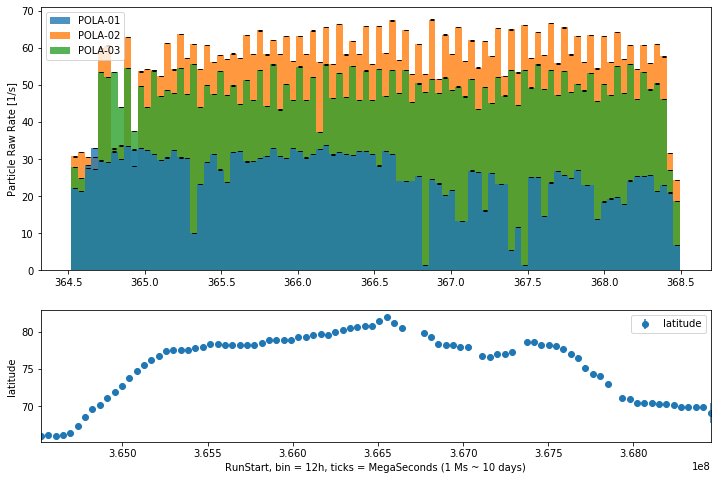

In [217]:
fig, ax = plt.subplots(2,  gridspec_kw={'height_ratios': [2., 1]})
plot_bars_from_pivot(ax[0],
                     binned_agg(runs, "RunStart", "NumEvents", lambda x: np.sum(x)/(60*60*12), 60*60*12, agg_err=lambda x: np.sqrt(x.sum())/(60*60*12)).reset_index(level=1, drop=False),
                     "RunStart",
                     "NumEvents",
                     xscale=1E6)
show_sorted_legend(ax[0])
ax[0].set_ylabel("Particle Raw Rate [1/s]");
binned_agg(runs, "RunStart", "latitude", np.mean, 60*60*12).loc["POLA-01"].plot(y="latitude", yerr="latitude_err", ls="none", marker="o", ax=ax[1])
ax[1].legend()
ax[1].set_xlabel("RunStart, bin = 12h, ticks = MegaSeconds (1 Ms ~ 10 days)");
ax[1].set_ylabel("latitude");

### 3.2.1 Longitude and latitude

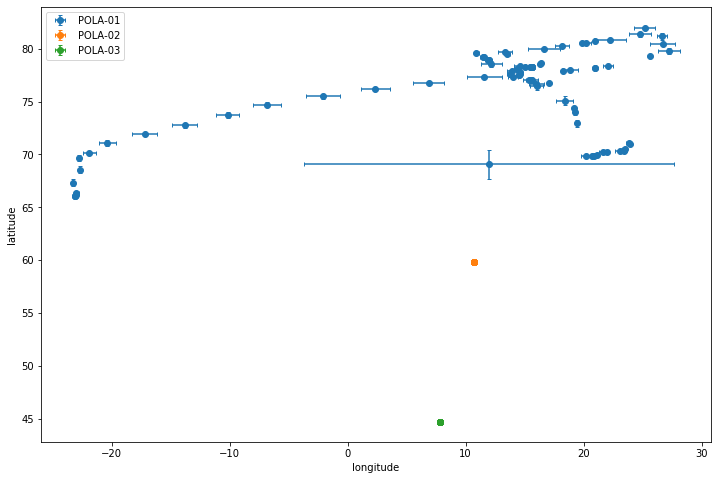

In [214]:
fig, ax = plt.subplots()
plot_scatter_from_pivot(ax,
                        pivot_on_binned_time(runs, "longitude", np.mean, np.std, 60*60*12, on="Seconds", ylabel="latitude", yagg=np.mean, yagg_err=np.std),
                        "longitude",
                        "latitude")
show_sorted_legend(ax)
ax.set_xlabel("longitude")
ax.set_ylabel("latitude");

### Pressure and temperature

In [181]:
def plot_scatter_from_pivot(ax, pivot, xlabel, ylabel, xscale=1.):
    if not isinstance(ax, list):
        ax = itertools.repeat(ax)
    ax_iter = iter(ax)
    for tsc, tsc_color in avg_rate_color_map.items():
        ts = pivot.loc[tsc]
        next(ax_iter).errorbar(ts[xlabel]/xscale,
                               ts[ylabel].values,
                               yerr=ts[f"{ylabel}_err"].values,
                               xerr=ts[f"{xlabel}_err"].values,
                               fmt="o",
                               capsize=2,
                               color=tsc_color,
                               label=tsc)

We apply cut here, since dependency on time is not explicit, and noisy perturbation can't be eliminated by eye

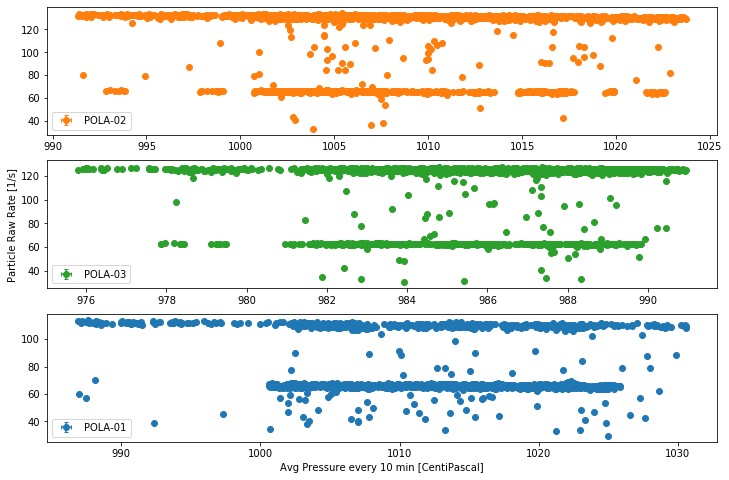

In [187]:
fig, ax = plt.subplots(3)
plot_scatter_from_pivot(list(ax),
                        pivot_on_binned_time(runs, "Pressure", np.mean, None, 60*10),
                        "Pressure",
                        "NumEvents",
                        xscale=1.)
show_sorted_legend(list(ax))
ax[2].set_xlabel("Avg Pressure every 10 min [CentiPascal]");
ax[1].set_ylabel("Particle Raw Rate [1/s]");

In [246]:
def binned_raw_rate(df, xlabel, binsize):
    duration = binned_agg(df, xlabel, "RunDuration", np.sum, binsize).reset_index(drop=False)
    tot_events = binned_agg(runs, xlabel, "NumEvents", np.sum, binsize, agg_err=lambda x: np.sqrt(x.sum())).reset_index(drop=False)
    merged = pd.merge(duration, tot_events, on=["telescope", xlabel])
    merged["NumEvents"] = merged["NumEvents"]/merged["RunDuration"]
    merged["NumEvents_err"] = merged["NumEvents_err"]/merged["RunDuration"]
    merged.drop(columns=["RunDuration", "RunDuration_err"], inplace=True)
    return merged.set_index(["telescope", xlabel])

In [282]:
def plot_binned_raw_rate(ax, binned_raw_rate):
    binsizes = []
    for tsc, tsdf in binned_raw_rate.groupby(level=0, as_index=False):
        xs = tsdf.loc[tsc].index.values
        binsize = np.median(xs[1:] - xs[:-1])
        binsizes.append(binsize)
        ax.bar(xs, tsdf["NumEvents"], binsize, label=tsc, yerr=tsdf["NumEvents_err"], alpha=0.85, align="edge")
    ax.legend()
    ax.set_xlabel(f"{binned_raw_rate.index.names[1]}, binsize={np.mean(binsizes)}")
    ax.set_ylabel("RawRate [1/s]")

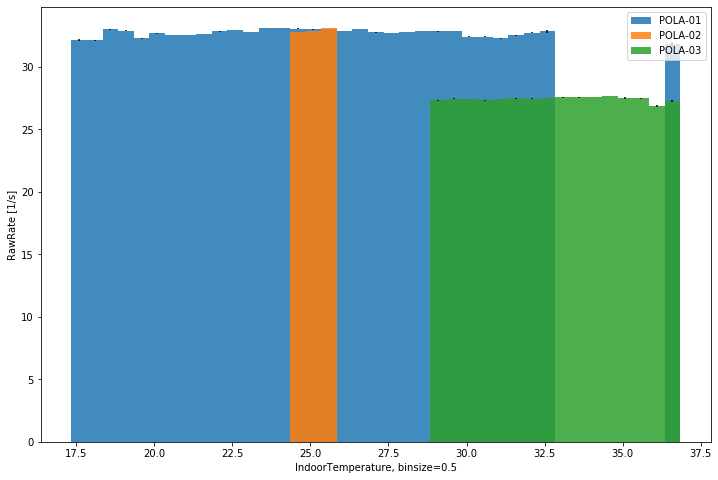

In [283]:
fig, ax = plt.subplots()
plot_binned_raw_rate(ax,
                     binned_raw_rate(runs, "IndoorTemperature", 0.5))

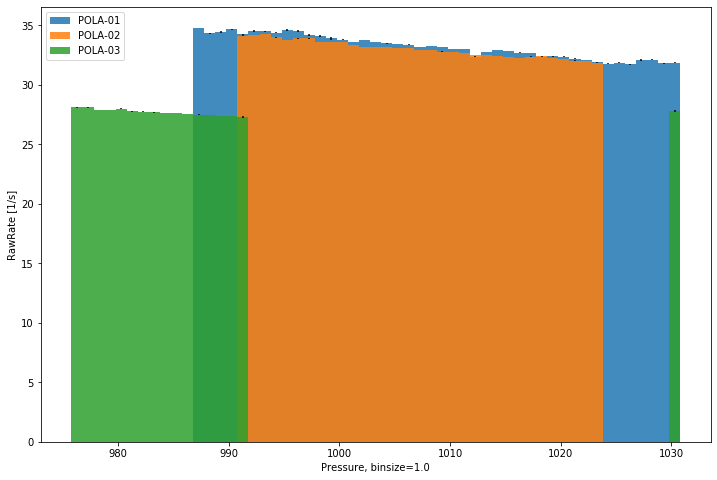

In [284]:
fig, ax = plt.subplots()
plot_binned_raw_rate(ax,
                     binned_raw_rate(runs, "Pressure", 1))

Notice bumps at the right edge of histogram. It is something to do with searchsorted. FIX!!